In [15]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
import numpy as np
import scipy as sp
import scipy.io
import pandas as pd
from sklearn import decomposition, linear_model, cross_validation
from sklearn.cross_decomposition import PLSRegression, PLSCanonical, CCA
from sklearn.kernel_ridge import KernelRidge
from sklearn.preprocessing import PolynomialFeatures
#from sklearn.ensemble import ExtraTreesRegressor
#from sklearn.neighbors import KNeighborsRegressor

#from sklearn.decomposition import PCA
#from sklearn import linear_model
#import statsmodels.api as sm
#import statsmodels.formula.api as smf
%config InlineBackend.figure_format='retina'

#seaborn generates spurious warnings with pandas
#Suppress them until updated versions are pushed (due ~Dec 2015)
import warnings
warnings.filterwarnings('ignore') 
#warnings.filterwarnings('default')

In [2]:
"""Import Matlab data file"""
mat = scipy.io.loadmat('eigendat.mat')
params = mat['params']
freq = mat['freq']
pwr = mat['pwr']

In [3]:
X = pd.DataFrame(params) #input matrix (86,37)
X.index.name = 'Sample #'
X.columns.name = 'Parameters'
Y = pd.DataFrame(pwr,columns=np.mean(freq,0)) #output matrix (86,1000)
Y.index.name = 'Sample #'
Y.columns.name = 'Freq (Hz)'

#Downsample the frequency bins
Y = Y.iloc[:,::10]

#Remove first 20 samples (which look different)
#X = X.iloc[20:,:]
#Y = Y.iloc[20:,:]

"""Standardize or just center each feature"""
zscore = lambda z: (z - z.mean())/z.std()
ctr = lambda z: (z-z.mean())
Xz = X.apply(zscore).dropna(axis=1)
Yz = Y.apply(ctr).dropna(axis=1)

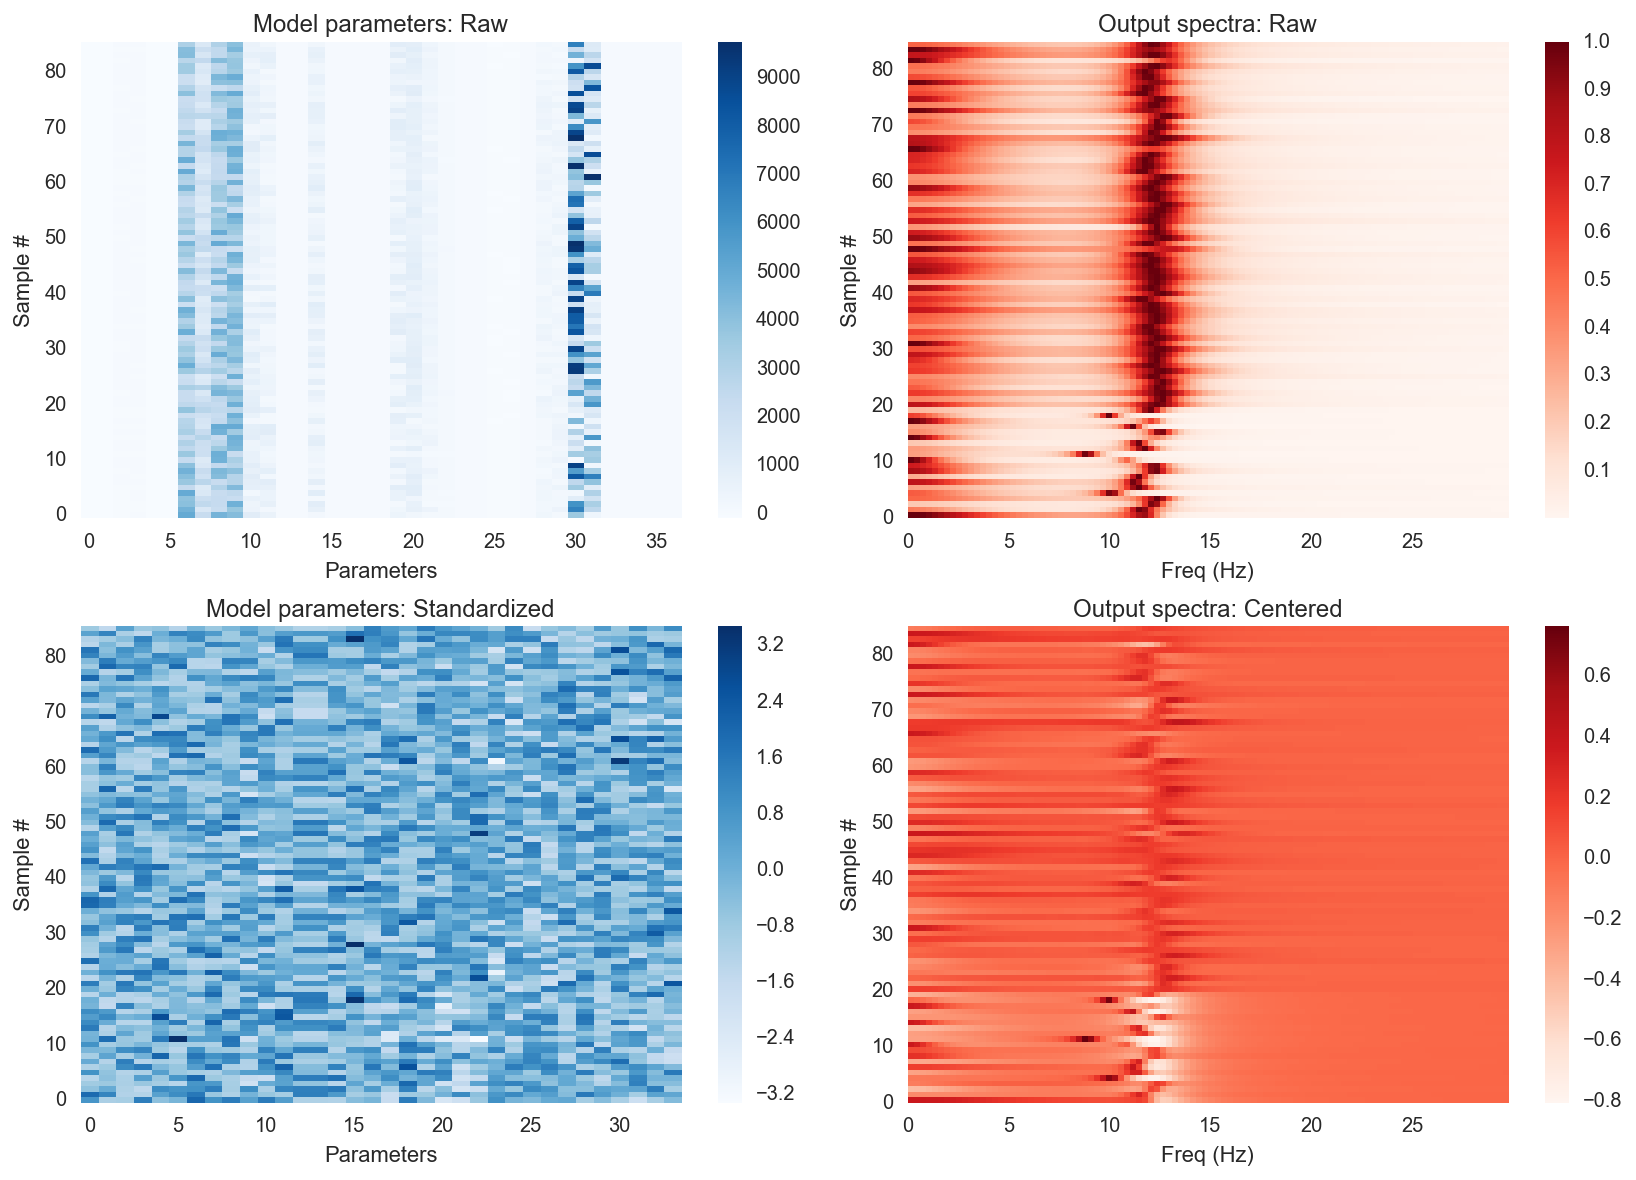

In [4]:
gs = plt.GridSpec(2, 2)
fig = plt.figure(figsize=(11.7, 8.27))

ax = fig.add_subplot(gs[0,0])
plt.imshow(X,interpolation='nearest',cmap='Blues',aspect='auto',origin='lower')
plt.title('Model parameters: Raw')
plt.grid(False)
ax.set_xlabel(X.columns.name)
ax.set_ylabel(X.index.name)
plt.colorbar()

ax = fig.add_subplot(gs[0,1])
plt.imshow(Y,interpolation='nearest',cmap='Reds',aspect='auto',origin='lower',
          extent=(Y.columns[0],Yz.columns[-1],Xz.index[0],Xz.index[-1]))
plt.title('Output spectra: Raw')
plt.grid(False)
ax.set_xlabel(Y.columns.name)
ax.set_ylabel(Y.index.name)
plt.colorbar()

ax = fig.add_subplot(gs[1,0])
plt.imshow(Xz,interpolation='nearest',cmap='Blues',aspect='auto',origin='lower')
plt.title('Model parameters: Standardized')
plt.grid(False)
ax.set_xlabel(Xz.columns.name)
ax.set_ylabel(Xz.index.name)
plt.colorbar()

ax = fig.add_subplot(gs[1,1])
plt.imshow(Yz,interpolation='nearest',cmap='Reds',aspect='auto',origin='lower',
          extent=(Yz.columns[0],Yz.columns[-1],Xz.index[0],Xz.index[-1]))
plt.title('Output spectra: Centered')
plt.grid(False)
ax.set_xlabel(Yz.columns.name)
ax.set_ylabel(Yz.index.name)
plt.colorbar()

fig.tight_layout()
#a=ax1.axes.get_xaxis().set_ticks([]) #suppress freq values for now to avoid clutter

### Model parameters are standardized (z-score) to remove different units (bottom left). Output spectra are centered on the average output but not standardized since the units for power in each freq bin are the same (bottom right). 

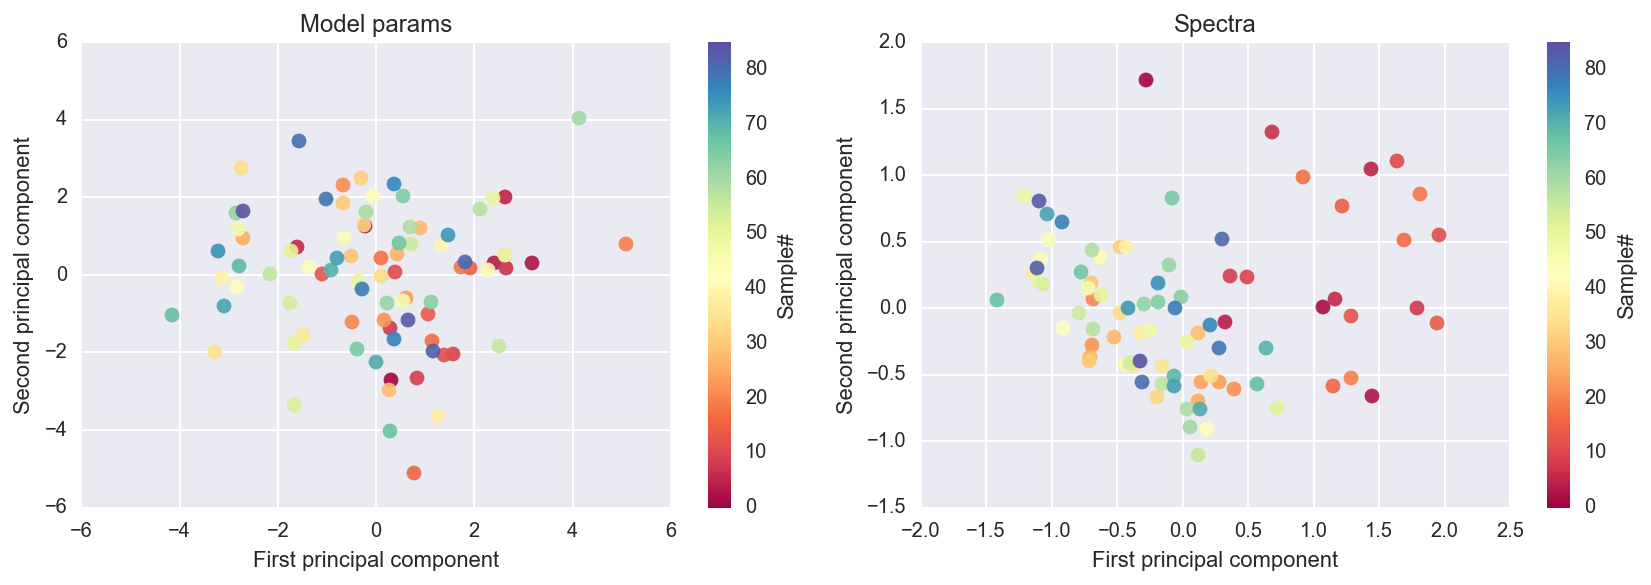

In [5]:
"""PCA"""
Xobj = decomposition.PCA()#n_components=2)
Xpca = Xobj.fit(Xz.values).transform(Xz.values)#y=pca.fit_transform(X.values)

YpcaMAX = 10 #max number of components to use for Y
Yobj = decomposition.PCA(n_components=YpcaMAX)
Ypca = Yobj.fit(Yz.values).transform(Yz.values)

gs = plt.GridSpec(1, 2)
fig = plt.figure(figsize=(11.7, 0.5*8.27))
#fig.suptitle('2 principal components (in both the input and output spaces)',fontsize=12)

"""Color palette and map"""
cmap_name = 'Spectral'
pal = sns.color_palette(cmap_name,X.shape[0])
cmap = plt.get_cmap(cmap_name)
fmax, fmin = Xz.index.max(), Xz.index.min()
scm = plt.cm.ScalarMappable(cmap=cmap, 
    norm=plt.Normalize(vmin=fmin, vmax=fmax))
scm._A = []

"""PCA for model parameters"""
ax = fig.add_subplot(gs[0,0])
for i in range(Xz.index.shape[0]):
    ax.scatter(Xpca[i,0],Xpca[i,1],color=pal[i], alpha=0.9, s=50)
plt.title('Model params')
ax.set_xlabel('First principal component')
ax.set_ylabel('Second principal component')
cbar = fig.colorbar(scm,ax=ax)
cbar.ax.set_ylabel('Sample#')

"""PCA for spectra"""
ax = fig.add_subplot(gs[0,1])
for i in range(Yz.index.shape[0]):
    ax.scatter(Ypca[i,0],Ypca[i,1],color=pal[i], alpha=0.9, s=50)
plt.title('Spectra')
ax.set_xlabel('First principal component')
ax.set_ylabel('Second principal component')
cbar = fig.colorbar(scm,ax=ax)
cbar.ax.set_ylabel('Sample#')

fig.tight_layout()

### The first ~20 samples have principal components that are different to the others (red points in the figure on the right). This subset of samples appears to set the direction of the first PC.

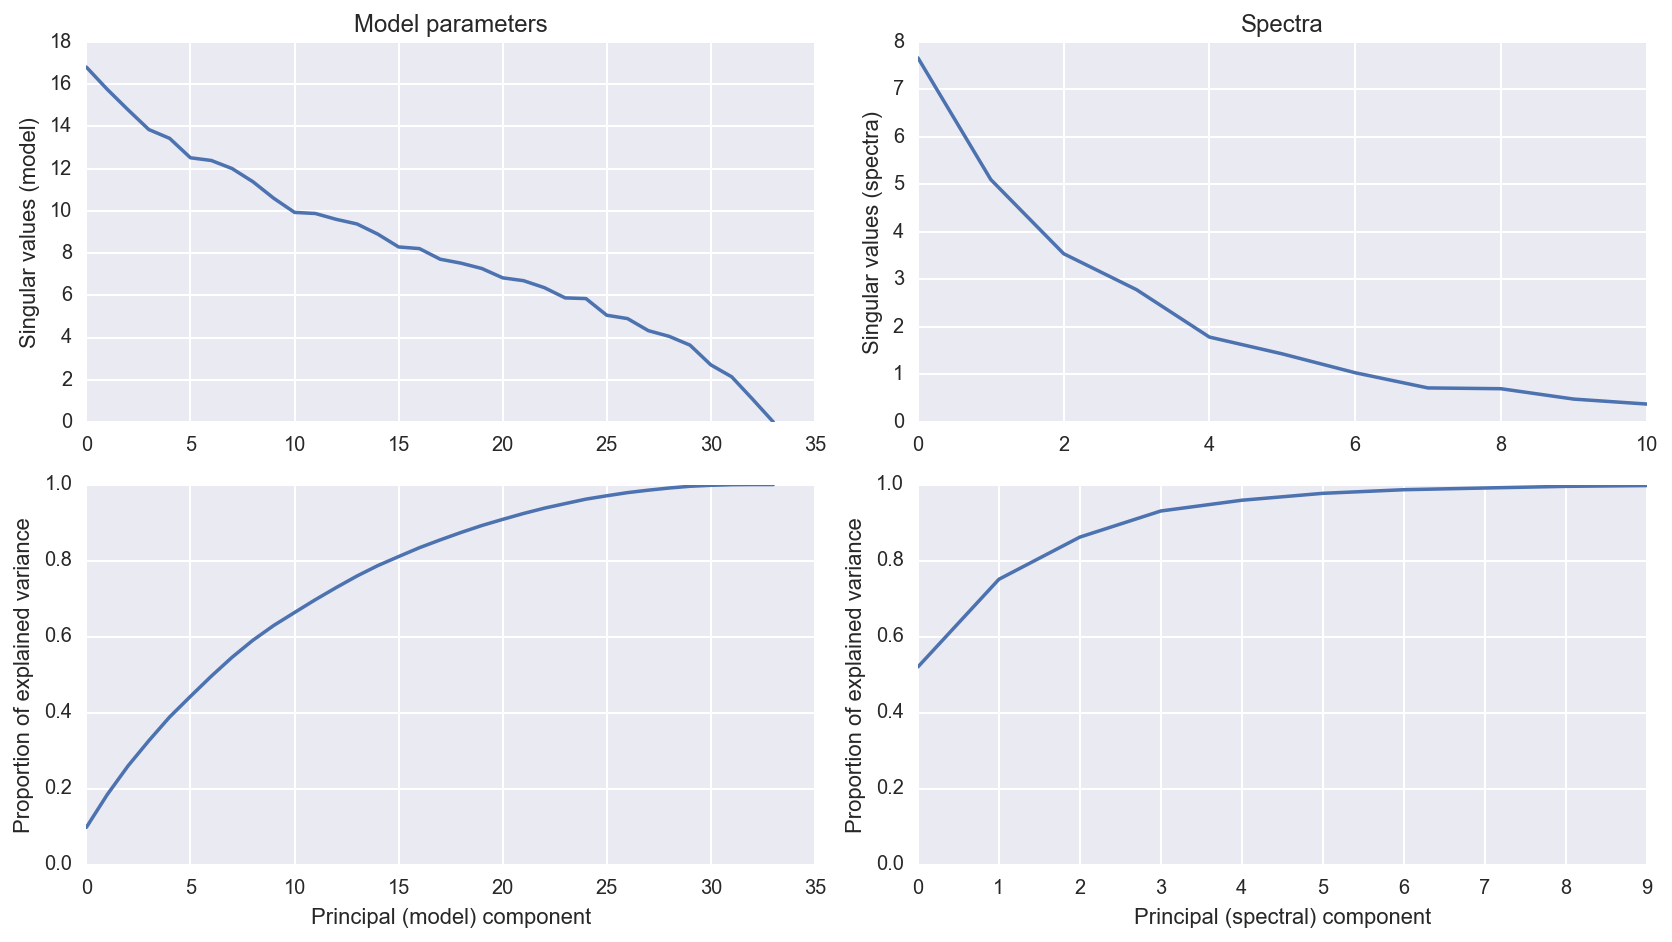

In [6]:
gs = plt.GridSpec(2, 2)
fig = plt.figure(figsize=(11.7, 0.8*8.27))

"""SVD to get singular values"""
UX, DX, VX = np.linalg.svd(Xz, full_matrices=True)
UY, DY, VY = np.linalg.svd(Yz, full_matrices=True)

"""Explained variance ratio vs PC"""
Xexpl = Xobj.explained_variance_ratio_.cumsum()
Xcomp = np.arange(Xexpl.shape[0])

Yexpl = Yobj.explained_variance_ratio_.cumsum()
Ycomp = np.arange(Yexpl.shape[0])

ax = fig.add_subplot(gs[0,0])
plt.plot(DX)
plt.title('Model parameters')
ax.set_ylabel('Singular values (model)')

ax = fig.add_subplot(gs[0,1])
plt.plot(DY)
plt.title('Spectra')
ax.set_xlim(0,YpcaMAX)
ax.set_ylabel('Singular values (spectra)')

ax = fig.add_subplot(gs[1,0])
plt.plot(Xcomp,Xexpl)
ax.set_ylim([0,1])
ax.set_xlabel('Principal (model) component')
ax.set_ylabel('Proportion of explained variance')

ax = fig.add_subplot(gs[1,1])
plt.plot(Ycomp,Yexpl)
#ax.set_xlim([0,10])
ax.set_ylim([0,1])
ax.set_xlabel('Principal (spectral) component')
ax.set_ylabel('Proportion of explained variance')

fig.tight_layout()

### The first 4 principal components of the spectra contain ~95% of the variance (bottom right). Most of the information from the spectra thus exists in a 4-dimensional subspace, making the inverse problem back to 33 model parameters challenging. 

alpha = 100
(34, 100)


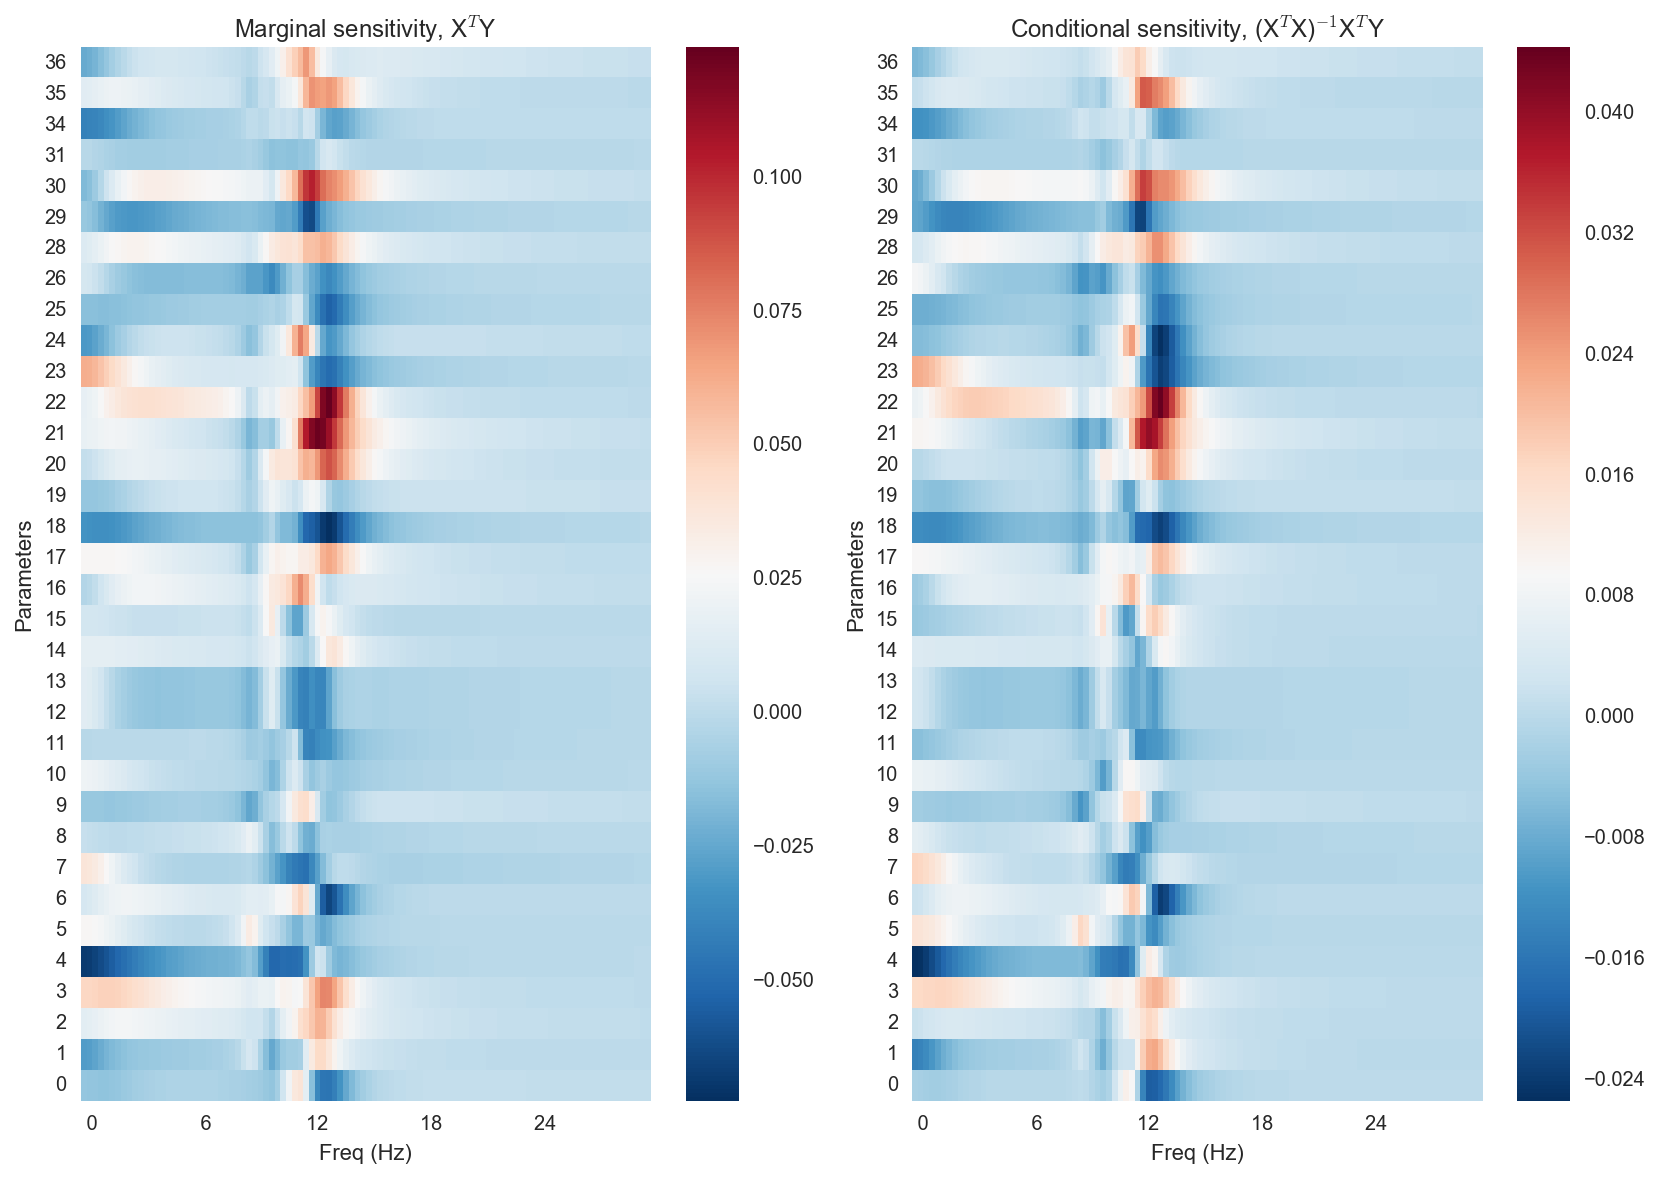

In [7]:
"""Marginal sensitivity (= Cross-covariance matrix)"""
covXY = Xz.transpose().dot(Yz)/Yz.shape[0]   # X^T * Y (X crossed with Y)

"""Conditional sensitivity (= linear regression coefficients)
Even though X^T*X is not ill-conditioned, inferring ~34 fitting parameters from 86 points will result
overfitting. Need to regularize - use cross-validation to determine regularization parameter alpha."""
#model = linear_model.LinearRegression() #Standard linear regression (results in overfitting)
model = linear_model.RidgeCV(alphas=np.arange(1,20)*10) #cross-validated ridge regression (avoids over-fitting)
beta = model.fit(Xz,Yz).coef_
beta = pd.DataFrame(beta.transpose(),columns=covXY.columns, index=covXY.index)

try:
    print('alpha = '+str(model.alpha_))
except:
    pass

gs = plt.GridSpec(1, 2)
fig = plt.figure(figsize=(11.7, 8.27))

"""Marginal sensitivity: Freq vs model parameters"""
ax = fig.add_subplot(gs[0,0])
plt.imshow(covXY,interpolation='nearest',cmap='RdBu_r',aspect='auto',origin='lower')

#Show all model parameter labels
plt.yticks(np.arange(covXY.index.shape[0]))
ax.set_yticklabels(covXY.index)

#Make sure frequency labeling is sparse and doesn't have too many decimal places
xticklabels=ax.get_xticks().tolist()
cff = np.polyfit(np.arange(covXY.columns.shape[0]), covXY.columns, 1)
xtickvals = np.polyval(cff,xticklabels)
xticks = ['% 4.0f' % v for v in xtickvals]
ax.set_xticklabels(xticks)

plt.title(r'Marginal sensitivity, X$^T$Y')
plt.grid(False)
ax.set_xlabel(covXY.columns.name)
ax.set_ylabel(covXY.index.name)
plt.colorbar()

"""Conditional sensitivity: Freq vs model parameters"""
ax = fig.add_subplot(gs[0,1])
plt.imshow(beta,interpolation='nearest',cmap='RdBu_r',aspect='auto',origin='lower')

#Show all model parameter labels
plt.yticks(np.arange(covXY.index.shape[0]))
ax.set_yticklabels(covXY.index)

#Make sure frequency labeling is sparse and doesn't have too many decimal places
xticklabels=ax.get_xticks().tolist()
print(beta.shape)
cff = np.polyfit(np.arange(beta.columns.shape[0]), beta.columns, 1)
xtickvals = np.polyval(cff,xticklabels)
xticks = ['% 4.0f' % v for v in xtickvals]
ax.set_xticklabels(xticks)

plt.title(r'Conditional sensitivity, (X$^T$X)$^{-1}$X$^T$Y')
plt.grid(False)
ax.set_xlabel(covXY.columns.name)
ax.set_ylabel(covXY.index.name)
plt.colorbar()

""" Freq vs PC of spectra"""
#covPY = Ypca.transpose().dot(Yz)/Yz.shape[0] # P^T * Y (PC's crossed with Y)

#ax = fig.add_subplot(gs[0,2])
#plt.imshow(covPY, interpolation='nearest', cmap='RdBu_r', aspect='auto',origin='lower')
#ax.set_xticklabels(xticks)

#plt.title("Covariance between PC's\n and spectrum")
#ax.set_xlabel('Freq')
#ax.set_ylabel('Principal (spectral) component')
#plt.colorbar()

fig.tight_layout()

## Conditional sensitivity has similar form to marginal, but is smaller, indicating strong shrinkage when obtaining the inverse (prior dominates the result). The large regularization parameter, $\alpha$, also suggests a highly overdetermined system (86 samples, 33 free parameters -> not surprising). Need to generate way more samples to better constrain the model.

## IGNORE EVERYTHING BELOW HERE

MSE = 0.00793320135136


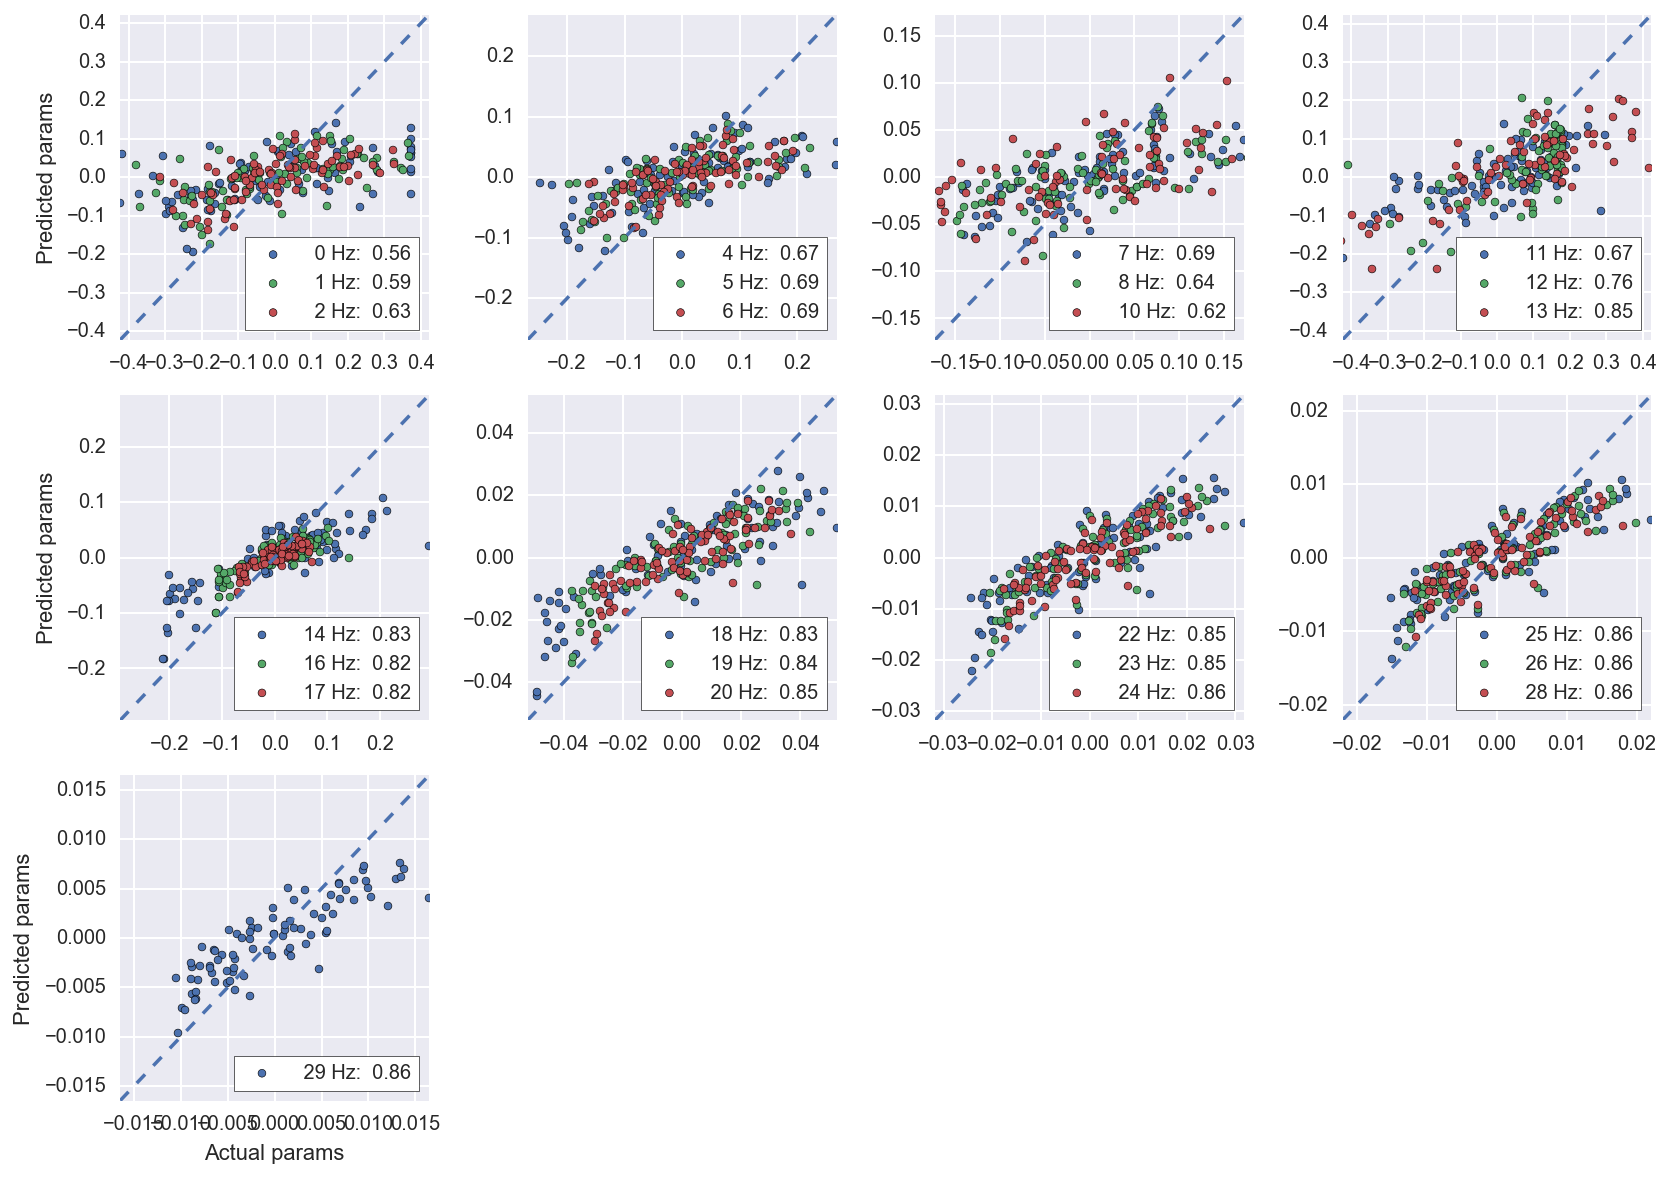

In [8]:
#estimator = linear_model.LinearRegression()
estimator = linear_model.Ridge(alpha=100)
#estimator = linear_model.RidgeCV(alphas=np.arange(1,20)*10) #cross-validated ridge regression (avoids over-fitting)
#estimator = PLSRegression(n_components=20) #Cross-decomposition: Partial least squares
#estimator = PLSCanonical(n_components=3) 
#estimator = CCA(n_components=3) #Cross-decomposition: Canonical correlation analysis
#estimator = KernelRidge(alpha=10)

#XX = pd.DataFrame(np.random.randn(100,15))
#YY = XX + 0.2*XX**2 #+ 0.3*XX**3 
#XX = XX.apply(lambda z: (z - z.mean())/z.std())

Input = Xz # input variables
Output = Yz.iloc[:,::4] # output variables

#Input = Input + np.random.randn(Input.shape[0],Input.shape[1])*0.01 #add "detector noise" to test robustness

#Decompose inputs to lower dimensions to minimize amplification of weak dimensions
#obj = decomposition.PCA(n_components=4)
#Input = obj.fit_transform(Input.values)#y=pca.fit_transform(X.values)

#Create polynomial features
#poly = PolynomialFeatures(2)#interaction_only=True)
#Input = poly.fit_transform(Input) ; print(Input.shape)

#Predict Output from Input
#Predicted = cross_validation.cross_val_predict(estimator, Input, Output, cv=None)
model = estimator.fit(Input,Output); Predicted = model.predict(Input)
Predicted = pd.DataFrame(Predicted, columns=Output.columns, index=Output.index)

try:
    print("alpha = " + str(model.alpha_))
except:
    pass

#Create list of indices labeling output parameters
#s = Output.shape
#params = np.reshape(np.tile(np.arange(s[1]),s[0]),(s[0], s[1]))

#Correlation between predicted and measured
pcorr = pd.Series(index=Output.columns)
for i in Output.columns:
    pcorr.loc[i] = Output[i].corr(Predicted[i])
    
#Sort features by correlation (highest first)    
#pcorr = pcorr.sort_values(ascending=False)

nrows = 3
ncols = 4
nperfig = 3 # plots per fig

pal = sns.color_palette('deep')
gs = plt.GridSpec(nrows, ncols)
fig = plt.figure(figsize=(11.7, 8.27))

for i in range(Output.shape[1]):
    ia = int(i) % nperfig
    irow = int(i/nperfig/ncols)
    icol = int(i/nperfig) % ncols
    
    param = pcorr.index[i] #parameter index (sorted by correlation)
    cor = '%.2f' % pcorr.iloc[i]
    
    if ia == 0:
        ax = fig.add_subplot(gs[irow,icol])
        lim = Output.loc[:,param].abs().max()
        lims = [-lim, lim]
        plt.plot(lims, lims,'--',c=pal[0])
        ax.set_ylim(lims)
        ax.set_xlim(lims)
    #plt.scatter(Output.iloc[:,i], Predicted.iloc[:,i], s=15, c=pal[ia])
    plt.scatter(Output.loc[:,param], Predicted.loc[:,param], s=15, c=pal[ia],
                label='% 2.0f' % param +' Hz:  '+cor)
    
    if ia == nperfig-1 or i==Output.shape[1]-1:
        legend = ax.legend(loc='lower right', frameon=True)
        frame = legend.get_frame()
        frame.set_edgecolor('black')
        frame.set_facecolor('white')
    
    if icol == 0:
        ax.set_ylabel('Predicted params')
    
    if irow == nrows-1:
        ax.set_xlabel('Actual params')
        
fig.tight_layout()

residual = (Output - Predicted)**2
mse = residual.sum().sum() / residual.count().sum()
print("MSE = " + str(mse))

### Shrinkage effects are evident (slope is pushed towards zero)

In [9]:
#i,j = 23,43
#plt.scatter(Xz.iloc[:,i], Yz.iloc[:,j])
#print(Xz.shape, Yz.shape)

In [10]:
"""Covariance matrices for the partitioned multivariate problem. This does not take into account problems with
ill-conditioning and thus is probably suspect"""
covXX = Xz.transpose().dot(Xz)
covYY = Yz.transpose().dot(Yz)
covXY = Xz.transpose().dot(Yz)
covYX = Yz.transpose().dot(Xz)
icovXX = np.linalg.pinv(covXX)
icovYY = np.linalg.pinv(covYY) #Very ill-conditioned (hard to invert)

print(covXX.shape,covYY.shape,covXY.shape,covYX.shape,icovXX.shape,icovYY.shape)

covYY_X = covYY - np.dot(covYX, np.dot(icovXX, covXY))
icovYX = np.dot(covYX,icovXX)


(34, 34) (100, 100) (34, 100) (100, 34) (34, 34) (100, 100)


In [11]:
"""
gs = plt.GridSpec(2, 1)
fig = plt.figure(figsize=(11.7, 8.27))

ax = fig.add_subplot(gs[0,0])
plt.imshow(covYX,interpolation='nearest',cmap='RdBu_r',aspect='auto',origin='lower')
plt.title('Marginal sensitivity')
ax.set_xlabel('Input parameters')
ax.set_ylabel('Frequency')
plt.colorbar()

ax = fig.add_subplot(gs[1,0])
plt.imshow(icovYX,interpolation='nearest',cmap='RdBu_r',aspect='auto',origin='lower')
plt.title('Conditional sensitivity')
ax.set_xlabel('Input parameters')
ax.set_ylabel('Frequency')
plt.colorbar()

plt.tight_layout()
"""

"\ngs = plt.GridSpec(2, 1)\nfig = plt.figure(figsize=(11.7, 8.27))\n\nax = fig.add_subplot(gs[0,0])\nplt.imshow(covYX,interpolation='nearest',cmap='RdBu_r',aspect='auto',origin='lower')\nplt.title('Marginal sensitivity')\nax.set_xlabel('Input parameters')\nax.set_ylabel('Frequency')\nplt.colorbar()\n\nax = fig.add_subplot(gs[1,0])\nplt.imshow(icovYX,interpolation='nearest',cmap='RdBu_r',aspect='auto',origin='lower')\nplt.title('Conditional sensitivity')\nax.set_xlabel('Input parameters')\nax.set_ylabel('Frequency')\nplt.colorbar()\n\nplt.tight_layout()\n"

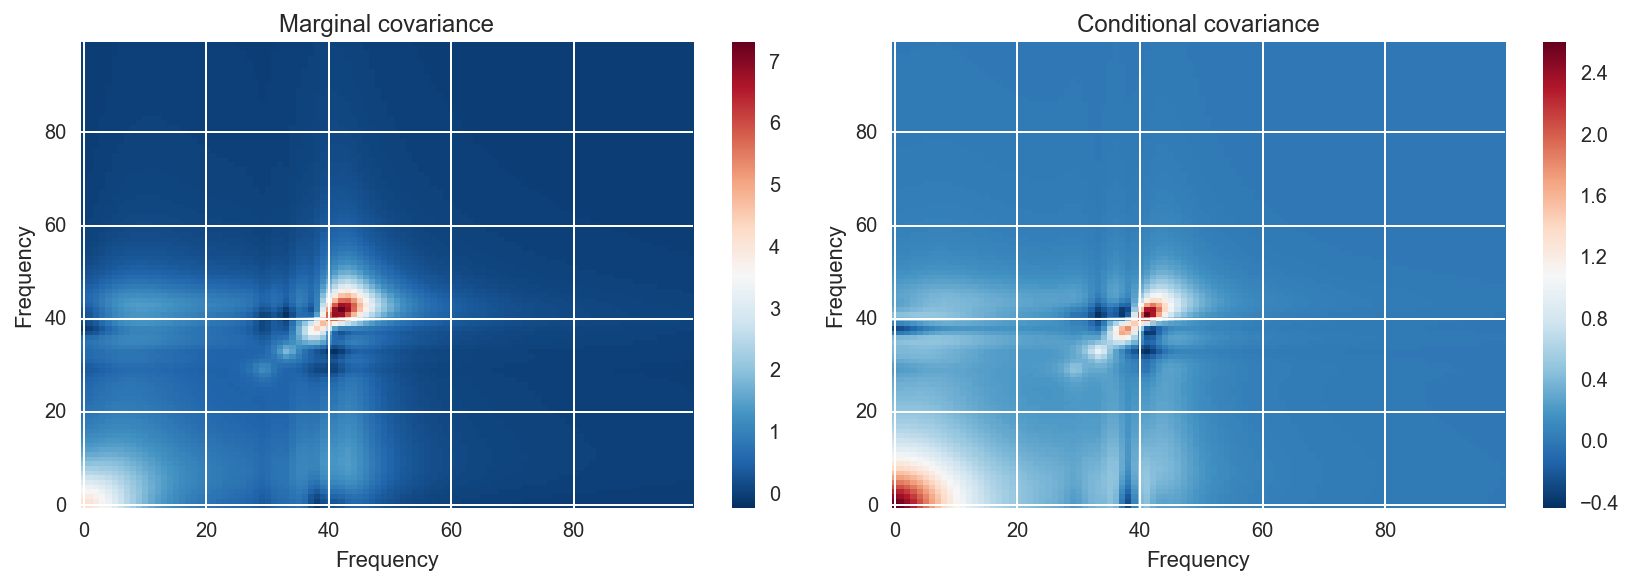

In [12]:
gs = plt.GridSpec(1, 2)
fig = plt.figure(figsize=(11.7, 0.5*8.27))

"""Marginal covariance"""
ax = fig.add_subplot(gs[0,0])
plt.imshow(covYY, interpolation='nearest',cmap='RdBu_r',aspect='auto',origin='lower')
plt.title('Marginal covariance')
ax.set_xlabel('Frequency')
ax.set_ylabel('Frequency')
plt.colorbar()

"""Conditional covariance"""
ax = fig.add_subplot(gs[0,1])
plt.imshow(covYY_X,interpolation='nearest',cmap='RdBu_r',aspect='auto',origin='lower')
plt.title('Conditional covariance')
ax.set_xlabel('Frequency')
ax.set_ylabel('Frequency')
plt.colorbar()

plt.tight_layout()

alpha = 23


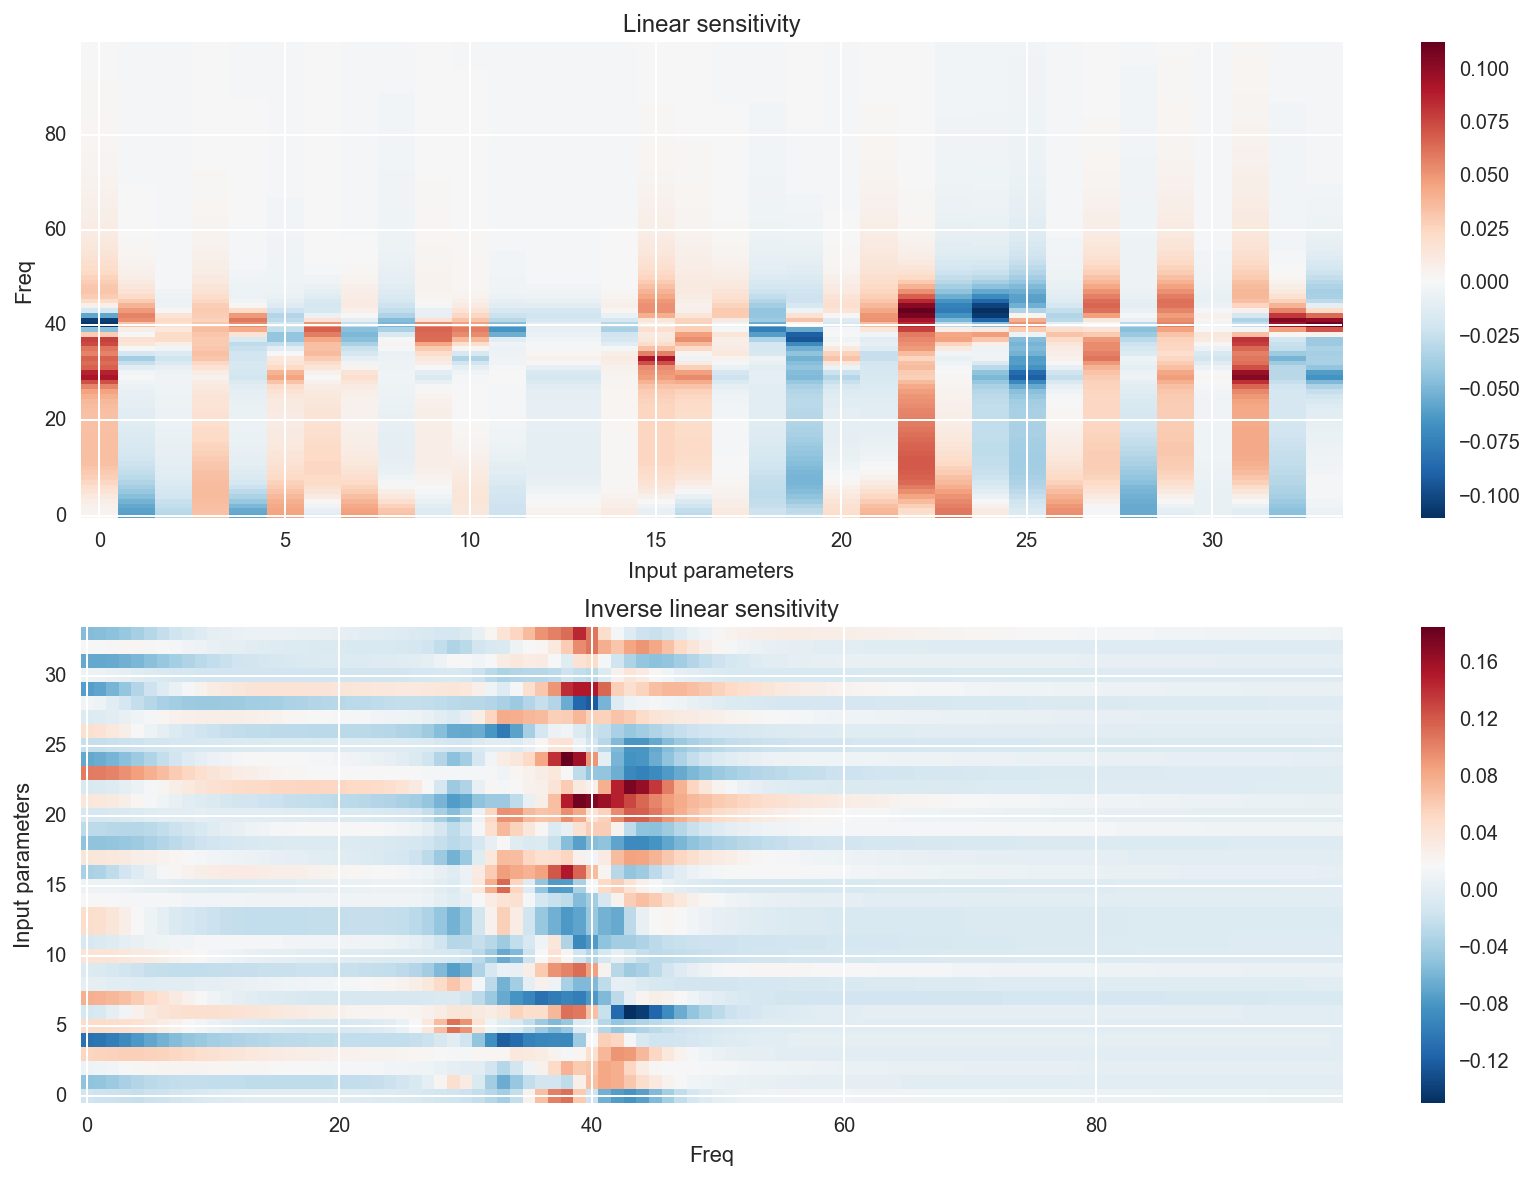

In [13]:
#clf_XY = linear_model.LinearRegression()
clf_XY = linear_model.Ridge(alpha=0.5)
cov_XY = clf_XY.fit(Xz,Yz).coef_

#clf_YX = linear_model.LinearRegression()
clf_YX = linear_model.RidgeCV(alphas=range(50)) #cross-validated ridge regression
cov_YX = clf_YX.fit(Yz,Xz).coef_
print('alpha = '+str(clf_YX.alpha_))

gs = plt.GridSpec(2, 1)
fig = plt.figure(figsize=(11.7, 8.27))

"""Freq vs input parameters"""
ax = fig.add_subplot(gs[0,0])
plt.imshow(cov_XY,interpolation='nearest',cmap='RdBu_r',aspect='auto',origin='lower')#,
ax.set_xlabel('Input parameters')
ax.set_ylabel('Freq')
plt.title('Linear sensitivity')
plt.colorbar()

ax = fig.add_subplot(gs[1,0])
plt.imshow(cov_YX,interpolation='nearest',cmap='RdBu_r',aspect='auto',origin='lower')
ax.set_xlabel('Freq')
ax.set_ylabel('Input parameters')
plt.title('Inverse linear sensitivity')
plt.colorbar()

plt.tight_layout()

MSE = 1.00172897752


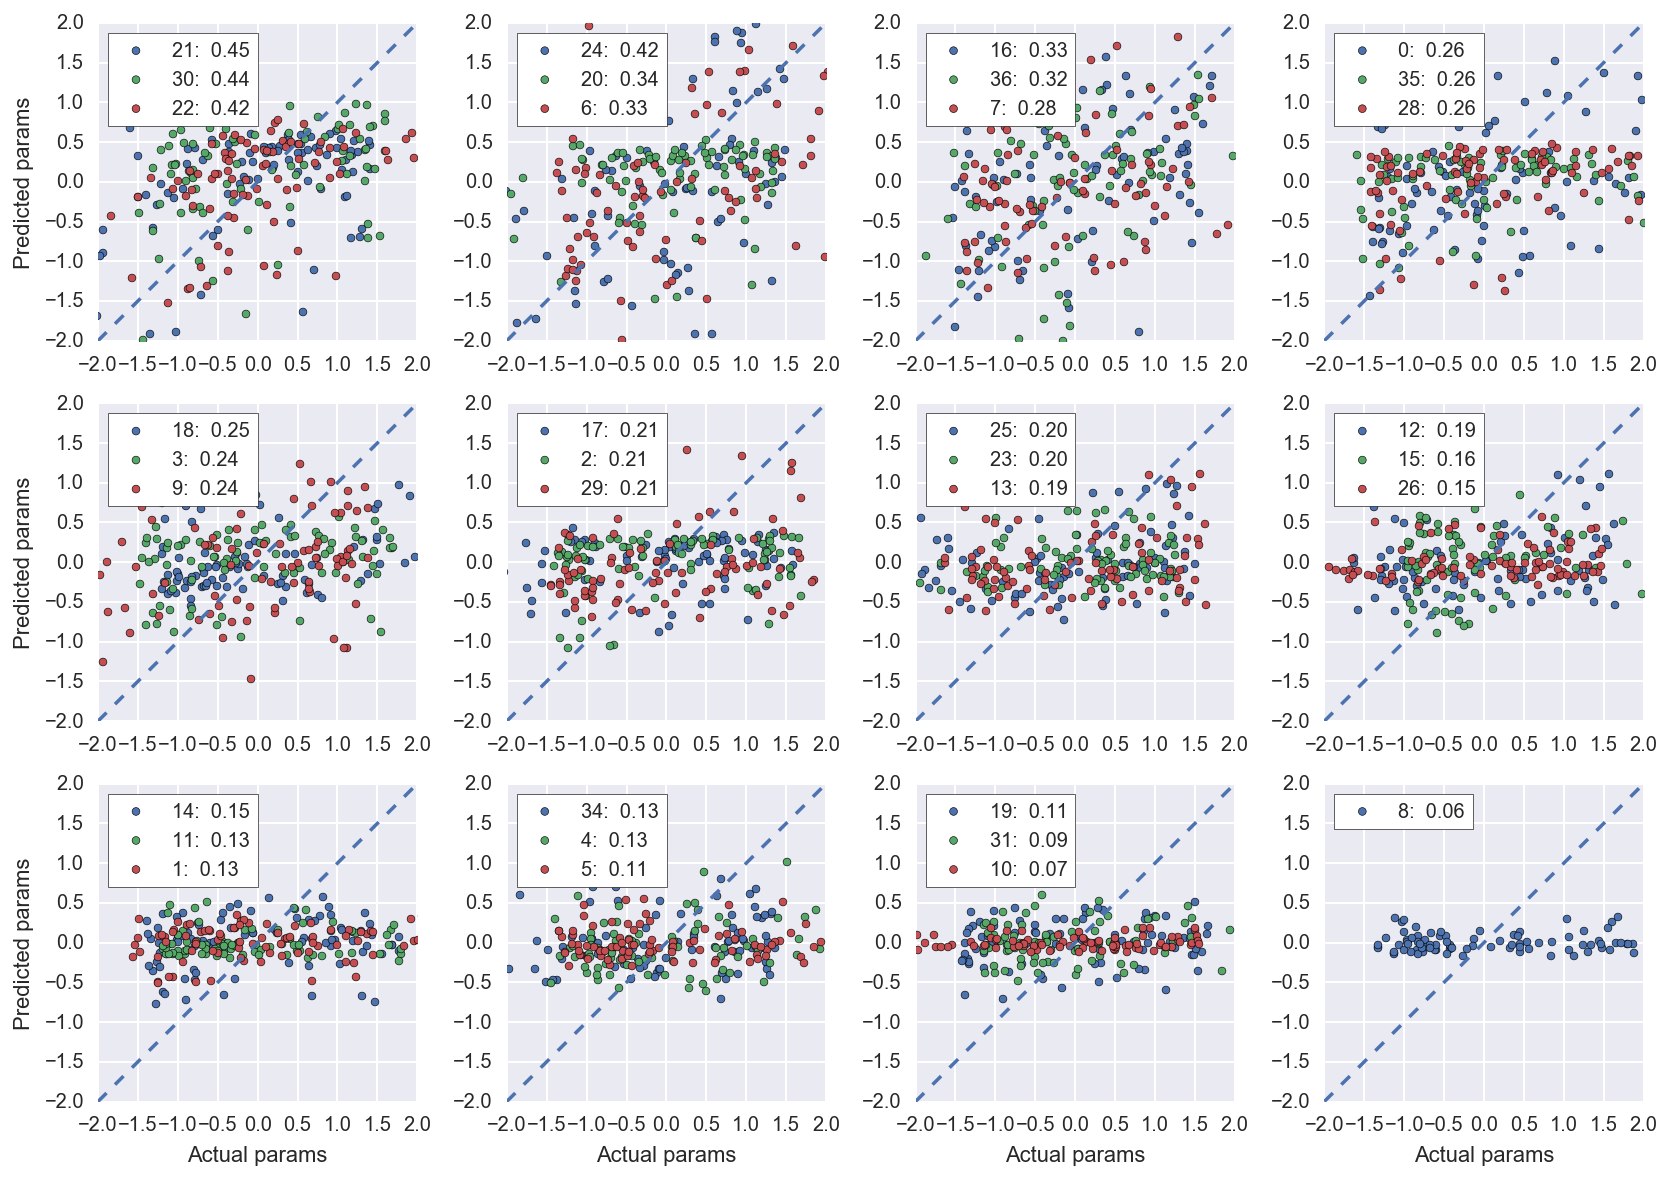

In [14]:
#estimator = linear_model.LinearRegression()
#estimator = linear_model.Ridge(alpha=23)
#estimator = linear_model.RidgeCV(alphas=range(50))
estimator = PLSRegression(n_components=2) #Cross-decomposition: Partial least squares
#estimator = PLSCanonical(n_components=3) 
#estimator = CCA(n_components=3) #Cross-decomposition: Canonical correlation analysis
#estimator = KernelRidge(alpha=10)

#XX = pd.DataFrame(np.random.randn(100,15))
#YY = XX + 0.2*XX**2 #+ 0.3*XX**3 
#XX = XX.apply(lambda z: (z - z.mean())/z.std())

Input = Yz # input variables
Output = Xz # output variables

#Input = Input + np.random.randn(Input.shape[0],Input.shape[1])*0.01 #add "detector noise" to test robustness

#Decompose inputs to lower dimensions to minimize amplification of weak dimensions
obj = decomposition.PCA(n_components=4)
Input = obj.fit_transform(Input.values)#y=pca.fit_transform(X.values)

#Create polynomial features
#poly = PolynomialFeatures(2)#interaction_only=True)
#Input = poly.fit_transform(Input) ; print(Input.shape)

#Predict Output from Input
#Predicted = cross_validation.cross_val_predict(estimator, Input, Output, cv=None)
model = estimator.fit(Input,Output); Predicted = model.predict(Input)
Predicted = pd.DataFrame(Predicted, columns=Output.columns, index=Output.index)

try:
    print("alpha = " + str(model.alpha_))
except:
    pass

#Create list of indices labeling output parameters
#s = Output.shape
#params = np.reshape(np.tile(np.arange(s[1]),s[0]),(s[0], s[1]))

#Correlation between predicted and measured
pcorr = pd.Series(index=Output.columns)
for i in Output.columns:
    pcorr.loc[i] = Output[i].corr(Predicted[i])
    
#Sort features by correlation (highest first)    
pcorr = pcorr.sort_values(ascending=False)

nrows = 3
ncols = 4
nperfig = 3 # plots per fig

pal = sns.color_palette('deep')
gs = plt.GridSpec(nrows, ncols)
fig = plt.figure(figsize=(11.7, 8.27))

for i in range(Output.shape[1]):
    ia = int(i) % nperfig
    irow = int(i/nperfig/ncols)
    icol = int(i/nperfig) % ncols
    
    param = pcorr.index[i] #parameter index (sorted by correlation)
    cor = '%.2f' % pcorr.iloc[i]
    
    if ia == 0:
        ax = fig.add_subplot(gs[irow,icol])
        plt.plot([-2,2],[-2,2],'--',c=pal[0])
        ax.set_ylim([-2,2])
        ax.set_xlim([-2,2])
    #plt.scatter(Output.iloc[:,i], Predicted.iloc[:,i], s=15, c=pal[ia])
    plt.scatter(Output.loc[:,param], Predicted.loc[:,param], s=15, c=pal[ia],
                label=str(param)+':  '+cor)
    
    if ia == nperfig-1 or i==Output.shape[1]-1:
        legend = ax.legend(loc='upper left', frameon=True)
        frame = legend.get_frame()
        frame.set_edgecolor('black')
        frame.set_facecolor('white')
    
    if icol == 0:
        ax.set_ylabel('Predicted params')
    
    if irow == nrows-1:
        ax.set_xlabel('Actual params')
        
fig.tight_layout()

residual = (Output - Predicted)**2
mse = residual.sum().sum() / residual.count().sum()
print("MSE = " + str(mse))